In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [2]:
def prepareData(df):
    capMln = []
    volMln=[]
    df=df.drop(['Name', 'SNo'], axis=1)
    for i in range(len(df['Marketcap'])):
        capMln.append(round(df['Marketcap'][i]/1000000, 6))
        volMln.append(round(df['Volume'][i]/1000000, 6))
    df['Marketcap']=capMln
    df['Volume']=volMln
    return df

In [3]:
bitcoin = prepareData(pd.read_csv('coin_Bitcoin.csv'))

In [4]:
link = prepareData(pd.read_csv('coin_ChainLink.csv'))

In [5]:
tron = prepareData(pd.read_csv('coin_Tron.csv'))

In [48]:
xrp = prepareData(pd.read_csv('coin_XRP.csv'))

In [7]:
eth = prepareData(pd.read_csv('coin_Ethereum.csv'))

In [8]:
stell = prepareData(pd.read_csv('coin_Stellar.csv'))

In [9]:
coins = pd.concat([bitcoin, link, tron, xrp, eth, stell])

In [39]:
xrp

,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,XRP,2013-08-05 23:59:59,0.005980,0.005613,0.005875,0.005613,0.000000,43.879157
1,XRP,2013-08-06 23:59:59,0.005661,0.004629,0.005637,0.004680,0.000000,36.591008
2,XRP,2013-08-07 23:59:59,0.004682,0.004333,0.004669,0.004417,0.000000,34.534121
3,XRP,2013-08-08 23:59:59,0.004424,0.004175,0.004397,0.004254,0.000000,33.258632
4,XRP,2013-08-09 23:59:59,0.004367,0.004253,0.004257,0.004291,0.000000,33.547503
...,...,...,...,...,...,...,...,...
2759,XRP,2021-02-23 23:59:59,0.570989,0.379302,0.570989,0.473563,14359.021786,21501.649334
2760,XRP,2021-02-24 23:59:59,0.499370,0.454759,0.474201,0.471832,8015.468859,21423.051553
2761,XRP,2021-02-25 23:59:59,0.482517,0.429103,0.471776,0.434524,5952.353924,19729.119199
2762,XRP,2021-02-26 23:59:59,0.450440,0.415559,0.434941,0.427900,6476.253874,19428.392307


In [11]:
# def plotCoins(coins):
#     numberOfCoins=len(coins)
#     fig, axs = plt.subplots(numberOfCoins, 2)
#     fig.set_figwidth(20)
#     fig.set_figheight(numberOfCoins*15)
#     fig.tight_layout(h_pad=5)
#     for i in range(len(coins)):
#         c = np.random.rand(3,)
#         axs[i][0].scatter(coins[i]['Low'], coins[i]['Marketcap'], color=c)
#         axs[i][0].set_title(coins[i]['Symbol'][0], fontsize=22)
#         axs[i][0].set_xlabel('Low', fontsize=18)
#         axs[i][0].set_ylabel('MarketCap', fontsize=18)
#         axs[i][1].scatter(coins[i]['High'], coins[i]['Marketcap'], color =c)
#         axs[i][1].set_title(coins[i]['Symbol'][0], fontsize=22)
#         axs[i][1].set_xlabel('High', fontsize=18)
#         axs[i][1].set_ylabel('MarketCap', fontsize=18)
        

In [49]:
# plotCoins([tron, xrp, eth, stell, bitcoin, link])

In [12]:
# coins_v2 = pd.get_dummies(coins['Symbol'])
# coins=pd.concat([coins,coins_v2], axis=1)

In [13]:
y = xrp['Close']
xrp = xrp.drop(['Close', 'Symbol', 'Date'], axis=1)

In [60]:
# Linear regression
def linearRegression(coinDf):
    y = coinDf['Close']
    coinDf = coinDf.drop(['Close', 'Symbol', 'Date'], axis=1)
    model = LinearRegression()
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False]}
    grid=GridSearchCV(model, parameters)
    grid.fit(coinDf, y)
    pred_y=cross_val_predict(grid, coinDf, y, cv=10)
    plt.scatter(pred_y, y)
    err = np.mean(mean_squared_error(y, pred_y))
    return grid.best_estimator_, err

(LinearRegression(fit_intercept=False, normalize=True), 0.00031281917907607644)

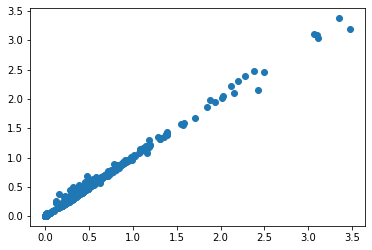

In [61]:
linearRegression(xrp)
# fit_intercept:True, normalize: True

In [69]:
# Polynomial regression
def polynomialRegression(coinDf):
#     parameters = {'degree':range(2,5), 'interaction_only':[True, False]}
    y = coinDf['Close']
    coinDf = coinDf.drop(['Close', 'Symbol', 'Date'], axis=1)
    model = PolynomialFeatures(degree=3)
#     grid=GridSearchCV(model, parameters)
    coinDf=model.fit_transform(coinDf)
    rgr = LinearRegression();
    rgr.fit(coinDf, y)
#     pred_train=cross_val_predict(grid, x_train, y_train, cv=10)
    pred_y=rgr.predict(coinDf)
    plt.scatter(pred_y, y)
    err = np.mean(mean_squared_error(y, pred_y))
    return err
#     return grid.best_estimator_

4.3272413009041146e-05

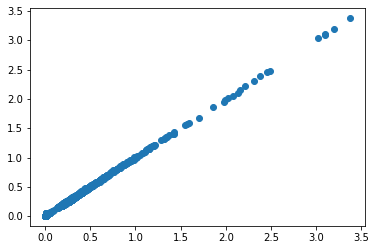

In [70]:
polynomialRegression(xrp)

In [67]:
# Ridge
def ridge(coinDf):
    y = coinDf['Close']
    coinDf = coinDf.drop(['Close', 'Symbol', 'Date'], axis=1)
    model = Ridge()
    parameters = {'alpha':range(1,5), 'fit_intercept':[True, False],'normalize':[True, False]}
    grid=GridSearchCV(model, parameters)
    grid.fit(coinDf, y)
    pred_y=cross_val_predict(grid, coinDf, y, cv=10)
    plt.scatter(pred_y, y)
    err = np.mean(mean_squared_error(y, pred_y))
    return grid.best_estimator_, err

[(Ridge(alpha=1, fit_intercept=False, normalize=True), 1.0817683510071886e-06),
 1.6460358615795602e-07,
 (LinearRegression(), 1.5967022815509276e-06)]

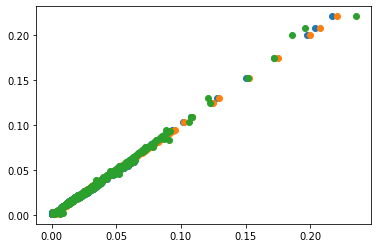

In [73]:
[ridge(tron), polynomialRegression(tron), linearRegression(tron)]

In [ ]:
### text
# The best model for this dataset according to the mean squared error is ridge